# CNN

## 1. Imports

### 1.1 Setup for Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
 cd /content/drive/MyDrive/CNN

In [ ]:
ls

### 1.2 Install Depedencies

In [ ]:
#install dependencies
# !pip install -r requirements.txt

In [ ]:
import os
import copy
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms,models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import wandb
import time
from datetime import datetime

### 1.2 Global Variables

In [ ]:
EPOCHS = 30
CLASSES = 7
BATCH_SIZE = 32
NUM_WORKERS = 4 # change based on specification of computer
LEARNING_RATE = 0.001

In [ ]:
wandb.init(
    project="multimodal_cnn",
    name="early_fusion_cnn",
    mode="offline",
    config={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "model": "CNN Early Fusion",
        "fusion_type": "addition"
    }
)

## 2. Load Data and Split

In [ ]:
#directories
rgbDir = ['RGB','RgbAug']
thermalDir = ['Thermal','ThermalAug']

### 2.1 Single Modality

In [ ]:
def loadDataSingleModality(modalDir):
    '''
    Loads and processes data from a single modality (either RGB or Thermal).
    Args:
        modalDir (list): List containing two directory paths - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of all image file paths.
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''

    #get list of files in the directory and combine them
    pairedFiles = []
    for data in modalDir:
        pairedFiles.extend(glob.glob(os.path.join(data, "*")))
    pairedFiles = sorted(pairedFiles)

    print(f'Total files: {len(pairedFiles)}')


    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in pairedFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For single modality testing (uaing raw and augmented data together)

#change this to test either thermal or rgb
modalDir = rgbDir

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataSingleModality(modalDir)

#for saving results later
if modalDir == rgbDir:
    savingLabel = "RGB"
else:
    savingLabel = "Thermal"

Total files: 20675
Data arranged as: tensor([0, 0, 0,  ..., 6, 6, 6])

Sample output:
File: RGB/R_Angry_10_KTFE.jpg
Label: Angry



### 2.2 Multi Modality

In [ ]:
def loadDataMultiModality(rgbDir,thermalDir):
    '''
    Loads and processes data from both RGB and Thermal modalities.
    Args:
        rgbDir (list): List containing two directory paths for RGB images - first for raw images, second for augmented images.
        thermalDir (list): List containing two directory paths for Thermal images - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of tuples, each containing a pair of (RGB image path, Thermal image path).
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''


    #get list of files in the directory and combine them
    rgbFiles = []
    thermalFiles = []
    for data in rgbDir:
        rgbFiles.extend(glob.glob(os.path.join(data, "*")))
    for data in thermalDir:
        thermalFiles.extend(glob.glob(os.path.join(data, "*")))

    #pairs thermal and rgb files together
    pairedFiles = list(zip(rgbFiles, thermalFiles))
    print(f"Total pairs: {len(pairedFiles)}")

    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in thermalFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For multi modality testing (using raw and augmented data together)

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataMultiModality(rgbDir,thermalDir)

Total pairs: 20675
Data arranged as: tensor([5, 5, 5,  ..., 0, 0, 0])

Sample output:
File: ('RGB/R_Sad_2002_KTFE.jpg', 'Thermal/T_Sad_2117_KTFE.jpg')
Label: Sad



### 2.3 Split Data
- 80:20

In [ ]:

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    pairedFiles, tensorLabels,
    test_size=0.2,
    stratify=tensorLabels,
    random_state=42
)
print(f'Train size: {len(X_train)}\nTest size: {len(X_test)}')

Train size: 16540
Test size: 4135


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 3. DataLoader

### 3.1 Single Modality

### 3.2 Multi Modality

In [ ]:
class MultiModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        rgbPath,thermalPath  = self.pairedFiles[idx]
        rgb = Image.open(rgbPath).convert('RGB')
        thermal = Image.open(thermalPath).convert('RGB') #try L greyscale

        if self.transform:
            rgb = self.transform(rgb)
            thermal = self.transform(thermal)

        label = self.labels[idx]
        return (rgb,thermal),label

train_dataset = MultiModalImageDataset(X_train, y_train, transform=transform)
test_dataset = MultiModalImageDataset(X_test, y_test, transform=transform)

### 3.3 Train and Test Loader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

## 4. ShuffleNet V.2

### 4.1 Single Modality

### 4.2 Multi Modality

In [ ]:
class EarlyFusionFER(nn.Module):
    """
    Early Fusion CNN for FER using ShuffleNet backbone.
    Fusion happens at the input level: RGB + Thermal.
    """

    def __init__(self, num_classes: int = 7, fusion_type: str = "concat"):
        """
        Args:
            num_classes (int): Number of emotion classes
            fusion_type (str): "concat" → 6-channel input; "add" → 3-channel input
        """
        super().__init__()
        self.fusion_type = fusion_type

        #Backbone load pre-trained ShuffleNet V
        self.model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)


        # Reference adapt from PyTorch Forums discussion on changing input channels for pretrained models
        # https://discuss.pytorch.org/t/how-to-change-no-of-input-channels-to-a-pretrained-model/19379
        # https://discuss.pytorch.org/t/transfer-learning-how-to-modify-the-first-conv2d-layer-of-alexnet-to-accomodate-for-9-channel-input/4063

        # Modify first conv layer if concat
        if fusion_type == "concat":
            in_channels = 6
            old_conv = self.model.conv1[0]

            # Create a new convolutional layer with the correct input channels
            new_conv = nn.Conv2d(
                in_channels,
                old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=(old_conv.bias is not None)
            )

            # Initialise new conv weights
            with torch.no_grad():
                new_conv.weight[:, :3, :, :] = old_conv.weight   # RGB
                new_conv.weight[:, 3:, :, :] = old_conv.weight   # Thermal

                # Maintain bias setting from the original layer
                if old_conv.bias is not None:
                    new_conv.bias.copy_(old_conv.bias)

            # Replace the first conv layer
            self.model.conv1[0] = new_conv

        in_features = self.model.fc.in_features

        # Replace the final classifier to match num_classes
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, rgb, thermal):
        """
        Forward pass
        Args:
            rgb (Tensor): (B, 3, H, W)
            thermal (Tensor): (B, 3, H, W)
        Returns:
            logits (Tensor): (B, num_classes)
        """

        # Fuse RGB and Thermal at input level
        if self.fusion_type == "concat":
            fused = torch.cat([rgb, thermal], dim=1)  # (B, 6, H, W)
        elif self.fusion_type == "add":
            fused = rgb + thermal  # element-wise add  still (B, 3, H, W)
        else:
            raise ValueError(f"Unknown fusion_type: {self.fusion_type}")


        # Forward pass through ShuffleNet
        return self.model(fused)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialise multimodal model
model = EarlyFusionFER(num_classes=CLASSES, fusion_type="concat")
model.to(device)

# Loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# To collect data for plotting later
trainLosses = []
testAccuracies = []

# For saving results
savingLabel = "MultiModal_EarlyFusion"

# Training timing setup
print("Starting training...")
training_start_time = time.time()
training_start_datetime = datetime.now()
print(f"Training started at: {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

# Training loop
for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    model.train()
    runningTrain = 0

    # Training batches
    for (rgb, thermal), y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        rgb, thermal, y = rgb.to(device), thermal.to(device), y.to(device)
        optimiser.zero_grad()

        outputs = model(rgb, thermal)
        loss = criterion(outputs, y)
        loss.backward()
        optimiser.step()

        runningTrain += loss.item() * rgb.size(0)

    # Epoch training loss
    trainLoss = runningTrain / len(train_loader.dataset)
    trainLosses.append(trainLoss)


    model.eval()
    accPre = 0
    totalDatapoints = 0

    # Reset arrays for predictions and targets
    predictionsArr = []
    targetsArr = []

    for (rgb, thermal), target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        rgb, thermal, target = rgb.to(device), thermal.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(rgb, thermal)
            predicted = outputs.argmax(1)

            # Collect predictions and targets
            predictionsArr.extend(predicted.cpu().numpy().tolist())
            targetsArr.extend(target.cpu().numpy().tolist())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)

    finalAcc = accPre / totalDatapoints
    testAccuracies.append(finalAcc)

    # Calculate epoch time
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    elapsed_time = epoch_end_time - training_start_time

    # Print epoch results
    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}, "
          f"Epoch Time = {epoch_duration/60:.2f} min, Total Time = {elapsed_time/60:.2f} min")

# Training completion timing
training_end_time = time.time()
training_end_datetime = datetime.now()
total_training_time = training_end_time - training_start_time

# Final results
print(f"\nTraining completed..")
print(f"Training started at:  {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training ended at:    {training_end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time:  {total_training_time/3600:.2f} hours ({total_training_time/60:.2f} minutes)")
print(f"Best Test Accuracy: {max(testAccuracies):.4f}")
print(f"Final Test Accuracy: {testAccuracies[-1]:.4f}")

Starting training...
Training started at: 2025-09-02 02:24:59


Epoch 1 Evaluating: 100%|██████████| 65/65 [02:45<00:00,  2.55s/it]


Epoch 1: Train Loss = 1.0061, Test Accuracy = 0.6895, Epoch Time = 8.80 min, Total Time = 8.80 min


Epoch 2 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.37it/s]


Epoch 2: Train Loss = 0.4512, Test Accuracy = 0.8418, Epoch Time = 2.25 min, Total Time = 11.05 min


Epoch 3 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


Epoch 3: Train Loss = 0.2650, Test Accuracy = 0.8706, Epoch Time = 2.28 min, Total Time = 13.33 min


Epoch 4 Evaluating: 100%|██████████| 65/65 [00:28<00:00,  2.29it/s]


Epoch 4: Train Loss = 0.1689, Test Accuracy = 0.8793, Epoch Time = 2.29 min, Total Time = 15.62 min


Epoch 5 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.37it/s]


Epoch 5: Train Loss = 0.1236, Test Accuracy = 0.8798, Epoch Time = 2.24 min, Total Time = 17.86 min


Epoch 6 Evaluating: 100%|██████████| 65/65 [00:28<00:00,  2.32it/s]


Epoch 6: Train Loss = 0.1151, Test Accuracy = 0.8982, Epoch Time = 2.28 min, Total Time = 20.14 min


Epoch 7 Evaluating: 100%|██████████| 65/65 [00:30<00:00,  2.16it/s]


Epoch 7: Train Loss = 0.0897, Test Accuracy = 0.8822, Epoch Time = 2.42 min, Total Time = 22.56 min


Epoch 8 Evaluating: 100%|██████████| 65/65 [00:31<00:00,  2.09it/s]


Epoch 8: Train Loss = 0.0687, Test Accuracy = 0.9110, Epoch Time = 2.43 min, Total Time = 24.99 min


Epoch 9 Evaluating: 100%|██████████| 65/65 [00:29<00:00,  2.23it/s]


Epoch 9: Train Loss = 0.0669, Test Accuracy = 0.9190, Epoch Time = 2.30 min, Total Time = 27.30 min


Epoch 10 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


Epoch 10: Train Loss = 0.0601, Test Accuracy = 0.9025, Epoch Time = 2.28 min, Total Time = 29.58 min


Epoch 11 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.34it/s]


Epoch 11: Train Loss = 0.0546, Test Accuracy = 0.9163, Epoch Time = 2.27 min, Total Time = 31.85 min


Epoch 12 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


Epoch 12: Train Loss = 0.0526, Test Accuracy = 0.8868, Epoch Time = 2.25 min, Total Time = 34.10 min


Epoch 13 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.36it/s]


Epoch 13: Train Loss = 0.0399, Test Accuracy = 0.9156, Epoch Time = 2.26 min, Total Time = 36.36 min


Epoch 14 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.35it/s]


Epoch 14: Train Loss = 0.0508, Test Accuracy = 0.9200, Epoch Time = 2.26 min, Total Time = 38.62 min


Epoch 15 Evaluating: 100%|██████████| 65/65 [00:28<00:00,  2.30it/s]


Epoch 15: Train Loss = 0.0437, Test Accuracy = 0.9149, Epoch Time = 2.29 min, Total Time = 40.90 min


Epoch 16 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


Epoch 16: Train Loss = 0.0509, Test Accuracy = 0.9040, Epoch Time = 2.24 min, Total Time = 43.15 min


Epoch 17 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.34it/s]


Epoch 17: Train Loss = 0.0411, Test Accuracy = 0.9219, Epoch Time = 2.27 min, Total Time = 45.42 min


Epoch 18 Evaluating: 100%|██████████| 65/65 [00:28<00:00,  2.30it/s]


Epoch 18: Train Loss = 0.0352, Test Accuracy = 0.9195, Epoch Time = 2.26 min, Total Time = 47.68 min


Epoch 19 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


Epoch 19: Train Loss = 0.0343, Test Accuracy = 0.9287, Epoch Time = 2.23 min, Total Time = 49.91 min


Epoch 20 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.35it/s]


Epoch 20: Train Loss = 0.0375, Test Accuracy = 0.9178, Epoch Time = 2.25 min, Total Time = 52.17 min


Epoch 21 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


Epoch 21: Train Loss = 0.0257, Test Accuracy = 0.9226, Epoch Time = 2.27 min, Total Time = 54.44 min


Epoch 22 Evaluating: 100%|██████████| 65/65 [00:28<00:00,  2.32it/s]


Epoch 22: Train Loss = 0.0326, Test Accuracy = 0.9282, Epoch Time = 2.26 min, Total Time = 56.70 min


Epoch 23 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


Epoch 23: Train Loss = 0.0255, Test Accuracy = 0.9190, Epoch Time = 2.26 min, Total Time = 58.95 min


Epoch 24 Evaluating: 100%|██████████| 65/65 [00:28<00:00,  2.27it/s]


Epoch 24: Train Loss = 0.0420, Test Accuracy = 0.9313, Epoch Time = 2.26 min, Total Time = 61.22 min


Epoch 25 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.39it/s]


Epoch 25: Train Loss = 0.0257, Test Accuracy = 0.9393, Epoch Time = 2.24 min, Total Time = 63.45 min


Epoch 26 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.38it/s]


Epoch 26: Train Loss = 0.0243, Test Accuracy = 0.9158, Epoch Time = 2.24 min, Total Time = 65.69 min


Epoch 27 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.36it/s]


Epoch 27: Train Loss = 0.0416, Test Accuracy = 0.9333, Epoch Time = 2.24 min, Total Time = 67.93 min


Epoch 28 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.37it/s]


Epoch 28: Train Loss = 0.0284, Test Accuracy = 0.9200, Epoch Time = 2.26 min, Total Time = 70.19 min


Epoch 29 Evaluating: 100%|██████████| 65/65 [00:26<00:00,  2.43it/s]


Epoch 29: Train Loss = 0.0335, Test Accuracy = 0.9349, Epoch Time = 2.22 min, Total Time = 72.41 min


Epoch 30 Evaluating: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]

Epoch 30: Train Loss = 0.0207, Test Accuracy = 0.9250, Epoch Time = 2.26 min, Total Time = 74.67 min

Training completed..
Training started at:  2025-09-02 02:24:59
Training ended at:    2025-09-02 03:39:39
Total training time:  1.24 hours (74.67 minutes)
Best Test Accuracy: 0.9393
Final Test Accuracy: 0.9250


## 5. Visualise and Save Results

### 5.1 Save Metrics

In [ ]:
saveResults = "trainingResults"
os.makedirs(saveResults, exist_ok=True)

#save training loss and accuracy to CSV
metrics = pd.DataFrame({'Epoch': range(1, len(trainLosses) + 1), 'Training Loss': trainLosses,'Test Accuracy': testAccuracies}) #create each row as epoch

#saves based on modality used
if savingLabel == "RGB":
  metrics.to_csv(os.path.join(saveResults, "metrics_RGB.csv"), index=False)
elif savingLabel == "Thermal":
  metrics.to_csv(os.path.join(saveResults, "metrics_Thermal.csv"), index=False)
else:
  metrics.to_csv(os.path.join(saveResults, "metrics_MultiModal_EarlyFusion.csv"), index=False)


### 5.2 Visualise Graphs

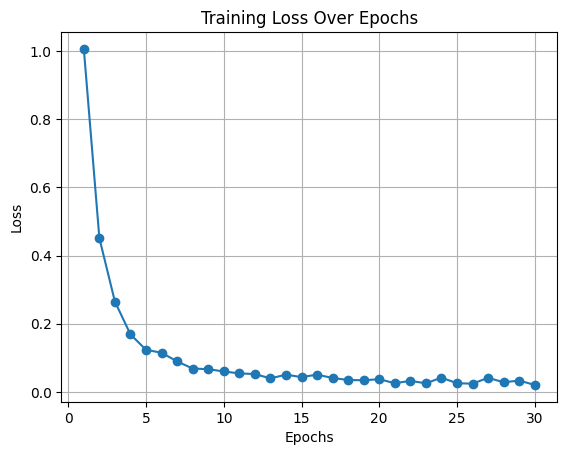

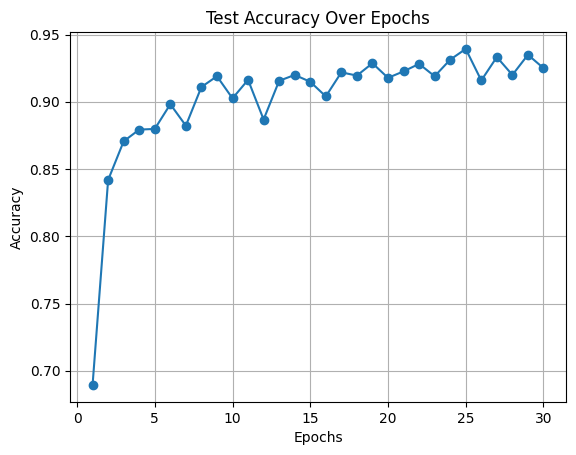

In [ ]:
# MULTIMODAL
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "MultiModal_EarlyFusion":
    plt.savefig(os.path.join(saveResults, "trainLoss_MultiModal_EarlyFusion.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modalžty used
if savingLabel == "MultiModal_EarlyFusion":
    plt.savefig(os.path.join(saveResults, "testAccuracy_MultiModal_EarlyFusion.png"))
plt.show()


Classification Report:
              precision    recall  f1-score   support

       Angry       0.87      0.96      0.91       779
     Disgust       0.96      0.97      0.97       221
        Fear       0.96      0.92      0.94       346
       Happy       0.90      0.92      0.91      1206
     Neutral       0.98      0.87      0.92       103
         Sad       0.99      0.96      0.97       882
   Surprised       0.94      0.83      0.89       598

    accuracy                           0.93      4135
   macro avg       0.94      0.92      0.93      4135
weighted avg       0.93      0.93      0.93      4135



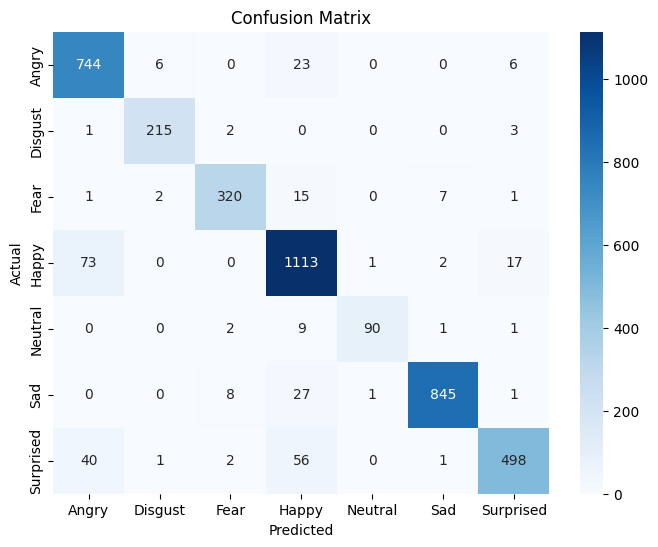

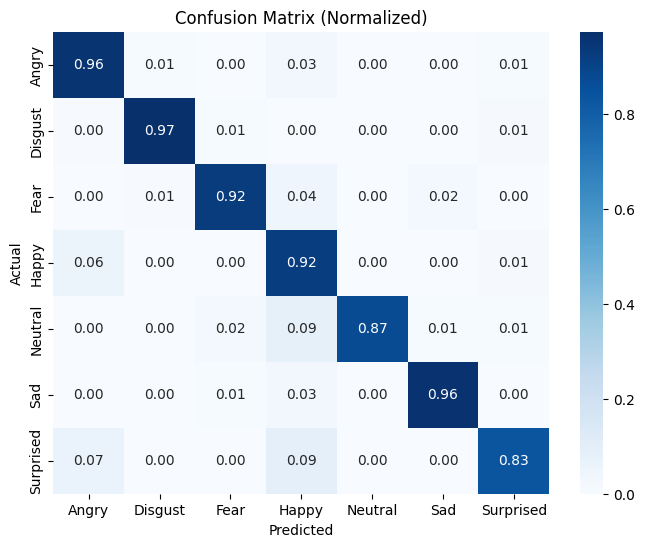

In [ ]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)
report = classification_report(targetsArr, predictionsArr, target_names=classNames)

print("\nClassification Report:")
print(report)

# Save classification report based on modality
if savingLabel == "RGB":
    with open(os.path.join(saveResults, "classificationReport_RGB.txt"), "w") as f:
        f.write(report)
elif savingLabel == "Thermal":
    with open(os.path.join(saveResults, "classificationReport_Thermal.txt"), "w") as f:
        f.write(report)
else:
    with open(os.path.join(saveResults, "classificationReport_MultiModal_EarlyFusion.txt"), "w") as f:
        f.write(report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classNames, yticklabels=classNames, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save figure based on modality
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_RGB.png"))
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_Thermal.png"))
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrix_MultiModal_EarlyFusion.png"))
plt.show()


# Normalized Confusion Matrix
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f",
            xticklabels=classNames, yticklabels=classNames, cmap="Blues")
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save figure based on modality
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrixNormalized_RGB.png"))
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "confusionMatrixNormalized_Thermal.png"))
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrixNormalized_MultiModal_EarlyFusion.png"))
plt.show()


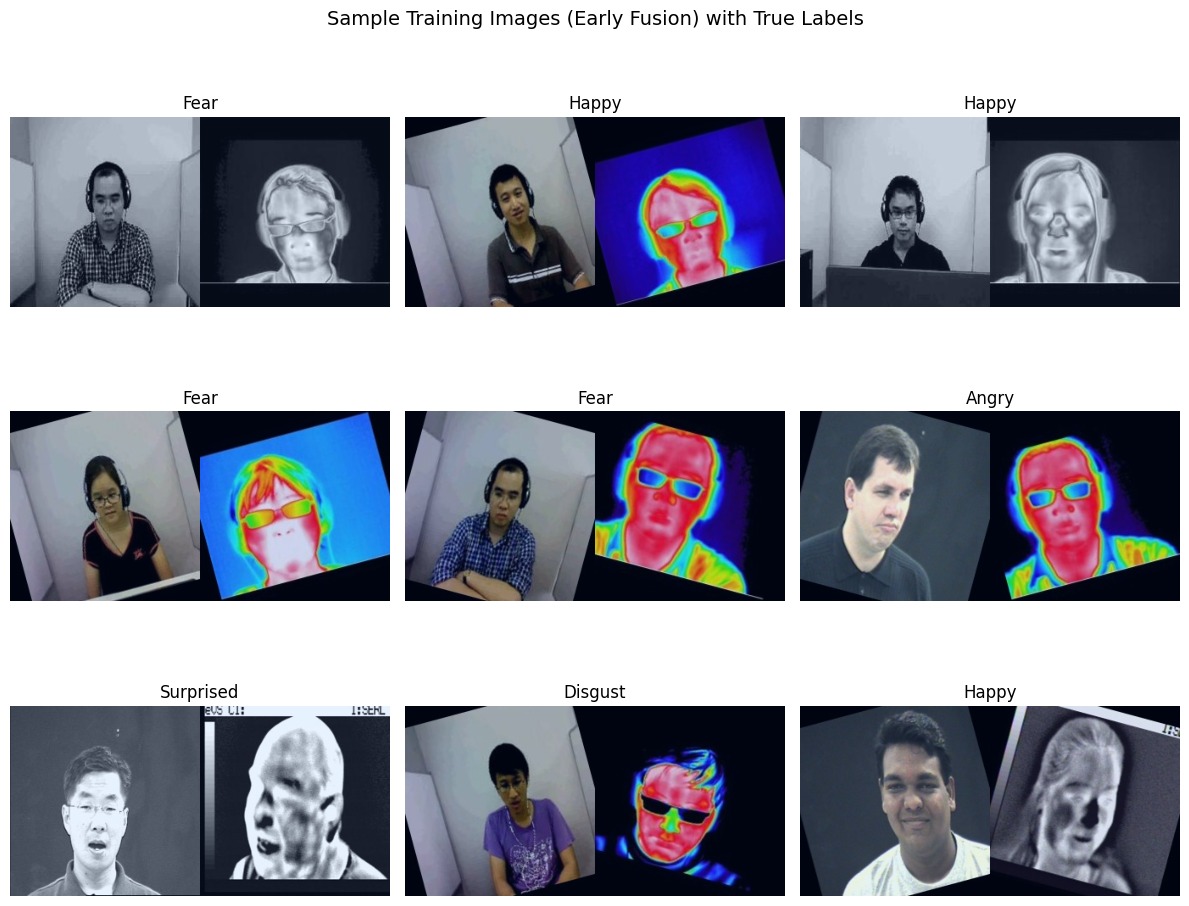

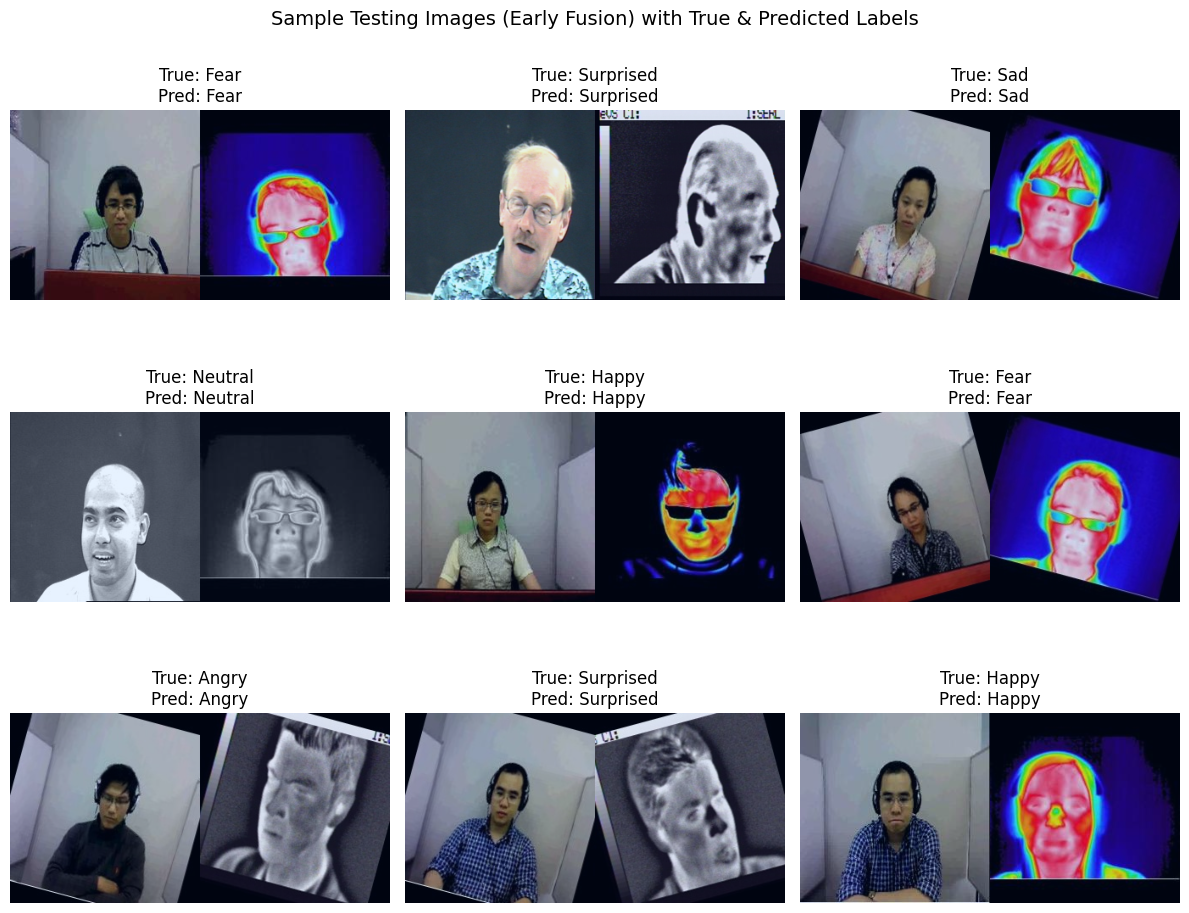

In [ ]:

# visualising Training Images (True Labels)

(rgb_batch, thermal_batch), labels_batch = next(iter(train_loader))

fig = plt.figure(figsize=(12, 10))
for i in range(9):  # show 9 samples
    ax = fig.add_subplot(3, 3, i+1)

    # Convert tensors to numpy
    rgb_img = np.transpose(rgb_batch[i].cpu().numpy(), (1, 2, 0))
    thermal_img = np.transpose(thermal_batch[i].cpu().numpy(), (1, 2, 0))

    # Combine side-by-side (RGB | Thermal)
    combined = np.concatenate([rgb_img, thermal_img], axis=1)

    # Normalize for display
    combined = (combined - combined.min()) / (combined.max() - combined.min())

    ax.imshow(combined)
    ax.set_title(classNames[labels_batch[i].item()])
    ax.axis('off')

plt.suptitle('Sample Training Images (Early Fusion) with True Labels', fontsize=14)
plt.tight_layout()
plt.show()

(rgb_batch, thermal_batch), labels_batch = next(iter(test_loader))
rgb_batch, thermal_batch = rgb_batch.to(device), thermal_batch.to(device)

# Run model predictions
model.eval()
with torch.no_grad():
    outputs = model(rgb_batch, thermal_batch)
    preds = outputs.argmax(1).cpu()

fig = plt.figure(figsize=(12, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)

    rgb_img = np.transpose(rgb_batch[i].cpu().numpy(), (1, 2, 0))
    thermal_img = np.transpose(thermal_batch[i].cpu().numpy(), (1, 2, 0))

    combined = np.concatenate([rgb_img, thermal_img], axis=1)
    combined = (combined - combined.min()) / (combined.max() - combined.min())

    ax.imshow(combined)
    true_label = classNames[labels_batch[i].item()]
    pred_label = classNames[preds[i].item()]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")

plt.suptitle("Sample Testing Images (Early Fusion) with True & Predicted Labels", fontsize=14)
plt.tight_layout()
plt.show()
